## Weakly Supervised Detection using Multiscale Class Attentive CutMix for Efficient Vector Mosquito Detection

# Procedure

- Generate training dataset using pre-cropped region proposals.
- Train backbone network (e.g: ResNet50) with a crop of region proposals in training set.
- Validate with bounding box labeled images with annotations.
    - Inference input image to the backbone network
    - From the final layer, acquire class activation maps.
    - Find contours of the channel-mean class activation maps.
    - Get coordinates of each instances, and compare with ground truth boxes.
    - Show mAP(%) for the result.



In [1]:
import os

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import cv2
import PIL.Image as Image

import matplotlib.pyplot as plt

from trainer import train, train_MACM, train_MCACM, test
from utils import Wrapper

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
def show_batch(input):
    input_ex = make_grid(input.detach().cpu(), normalize=True, nrow=8, padding=2).permute([1,2,0])
    fig, ax = plt.subplots(1,1,figsize=(8,(input.size(0)//8)+1))
    ax.imshow(input_ex)
    ax.set_title(f"Train Batch Examples")
    ax.axis('off')
    # fig.savefig(os.path.join(save_path, f"Train_BatchSample_E{cur_epoch}_I{idx}.png"))

Train/Val Split(0.7/0.3): 5976, 2562 (Sum: 8538)


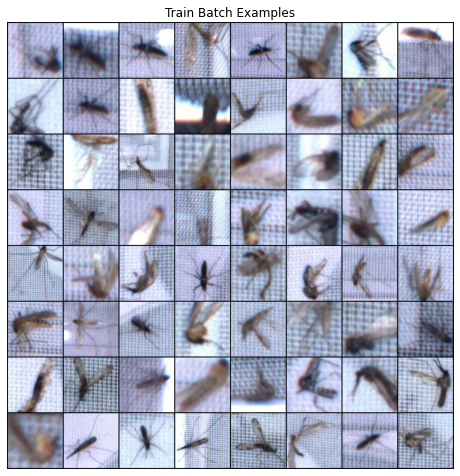

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
im_size = 112

train_transforms = transforms.Compose([
    transforms.ColorJitter(),
    transforms.Resize(im_size),
    transforms.RandomCrop(im_size),
    transforms.ToTensor(),
])

split_ratio = (0.7, 0.3)

whole_dataset = datasets.ImageFolder("~/datasets/MosquitoTrap2020_Confirmed/train", transform=train_transforms)
classes = whole_dataset.classes
num_classes = len(classes)

split_length = (int(len(whole_dataset)*split_ratio[0]), int(len(whole_dataset)*split_ratio[1])+1)

print(f"Train/Val Split({split_ratio[0]}/{split_ratio[1]}): {split_length[0]}, {split_length[1]} (Sum: {sum(split_length)})")

train_dataset, valid_dataset = torch.utils.data.random_split(whole_dataset, \
    [split_length[0], split_length[1]])

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=8)
valid_loader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=64, num_workers=8)


batch_sample = next(iter(train_loader))
show_batch(batch_sample[0])


In [4]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = Wrapper(model, stage_names=['layer4']).to(device)

Registered forward/backward hook on 'layer4'


In [5]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=4e-5, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

epochs = 20

epoch_train_loss = 0 
epoch_train_acc = 0

os.makedirs('test', exist_ok=True)

for cur_epoch in range(epochs):
    model, epoch_train_loss, epoch_train_acc = train(model, train_loader, optimizer, scheduler, criterion, cur_epoch, device, \
        flag_vervose=True, save_path='test')
    print(f"[{cur_epoch+1}/{epochs}] Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc*100:.2f}%")

state_dict = model.net.state_dict()

torch.save(state_dict, "tmp/test.pth")



[1/20] Loss: 0.7031, Acc: 74.46%
[2/20] Loss: 0.3317, Acc: 88.96%
[3/20] Loss: 0.2228, Acc: 92.09%
[4/20] Loss: 0.1650, Acc: 94.09%
[5/20] Loss: 0.1106, Acc: 95.87%
[6/20] Loss: 0.1098, Acc: 96.35%
[7/20] Loss: 0.0927, Acc: 96.82%
[8/20] Loss: 0.0655, Acc: 97.87%
[9/20] Loss: 0.0622, Acc: 98.08%
[10/20] Loss: 0.0632, Acc: 97.57%
[11/20] Loss: 0.0581, Acc: 98.13%
[12/20] Loss: 0.0570, Acc: 97.89%
[13/20] Loss: 0.0396, Acc: 98.59%
[14/20] Loss: 0.0245, Acc: 99.16%
[15/20] Loss: 0.0242, Acc: 99.26%
[16/20] Loss: 0.0141, Acc: 99.55%
[17/20] Loss: 0.0260, Acc: 99.21%
[18/20] Loss: 0.0240, Acc: 99.45%
[19/20] Loss: 0.0409, Acc: 98.64%
[20/20] Loss: 0.0297, Acc: 99.01%


In [17]:
target_image_path = '/home/ryan/datasets/MosquitoTrapCOCO/train/mark2_20201002_083020_jpg.rf.5e7ff2974746c8bd81d58d0906392b9f.jpg'

target_image = Image.open(target_image_path)
transform_target = transforms.Compose([
    transforms.Resize(2000),
    transforms.ToTensor()
])
target_image = transform_target(target_image)


In [13]:
pred = model(target_image.unsqueeze(0).to(device))


In [19]:
label = torch.Tensor([1]).long().to(device)

criterion = nn.CrossEntropyLoss()

loss = criterion(pred, label)
loss.backward()

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In [18]:
activation_maps = model.dict_activation['layer4']
gradient_maps = model.dict_gradients['layer4'][0]
print("Shape of activation maps: ", activation_maps.shape)
print("Shape of gradient maps: ", gradient_maps.shape)

Shape of activation maps:  torch.Size([1, 2048, 32, 32])
Shape of gradient maps:  torch.Size([1, 2048, 32, 32])


In [ ]:
import torch.nn.functional as F

F.avgpool2d(gradient_maps, 1)

In [16]:
fig, ax = plt.subplots(1,3, figsize=(30,10))
# plt.figure(figsize=(10,10))
ax[0].imshow(target_image.permute([1,2,0]))
ax[0].axis('off')
ax[1].matshow(activation_maps.mean(dim=1).squeez
e(0).detach().cpu(), cmap='viridis')
ax[2].matshow(gradient_maps.mean(dim=1).squeeze(0).detach().cpu(), cmap='viridis')


SyntaxError: invalid syntax (<ipython-input-16-09fd6554af31>, line 6)